In [17]:
import timeit 
from Ising_Model_Fast import *
import numpy as np
from numba import njit, prange
from pathlib import Path
import time

In [18]:
@njit(parallel=True)
def get_M_E_C_of_T_numba(lattice, energy, Ts, N, J1, J2, MC_steps, seed, use_last=1000):
    """Use Numba's parallelization for temperature loop"""
    n_temps = len(Ts)
    avg_mags = np.empty(n_temps, dtype=np.float32)
    avg_energies = np.empty(n_temps, dtype=np.float32)
    heat_capacities = np.empty(n_temps, dtype=np.float32)
    
    # Use prange for parallel execution
    for i in prange(n_temps):
        T = Ts[i]
        
        # Create a separate copy for each temperature
        local_lattice = lattice.copy()
        
        # Use deterministic but different seeds for each temperature
        local_seed = seed + i * 1000
        
        # Run the simulation
        mags, energies, _ = metropolis_large(
            local_lattice, 
            MC_steps, 
            T, 
            energy, 
            N, 
            J1, 
            J2, 
            local_seed
        )
        
        # Calculate statistics
        avg_mags[i] = np.mean(mags[-use_last:])
        avg_energies[i] = np.mean(energies[-use_last:])
        
        # Simple heat capacity calculation (may need to be replaced with your compute_specific_heat)
        e_mean = np.mean(energies[-use_last:])
        e2_mean = np.mean(energies[-use_last:]**2)
        heat_capacities[i] = (e2_mean - e_mean**2) / (N**2 * T)
    
    return avg_mags, avg_energies, heat_capacities

In [19]:
def simulate_all(p, Ns, Ts, MC_steps, J1, J2, seed, use_last=1000):

    lattices_N = [np.random.choice([1, -1], size=(N, N), p=[p, 1-p]) for N in Ns]
    lattices_N = [np.array(lattice, dtype=np.int8) for lattice in lattices_N]

    energies_N = [get_energy_fast(lattice, N, J1, J2) for lattice, N in zip(lattices_N, Ns)]
    energies_N = [np.array(energy, dtype=np.float32) for energy in energies_N]

    use_last = 1000

    n_Ns = len(Ns)
    n_Ts = len(Ts)

    avg_mags = np.empty((n_Ns, n_Ts), dtype=np.float32)
    avg_energies = np.empty((n_Ns, n_Ts), dtype=np.float32)
    heat_capacities = np.empty((n_Ns, n_Ts), dtype=np.float32)

    for i, N in enumerate(Ns):
        print(f"Running for N = {N}")
        lattice = lattices_N[i]
        energy = energies_N[i]
        avg_mags[i], avg_energies[i], heat_capacities[i] = get_M_E_C_of_T_numba(
            lattice, 
            energy, 
            Ts, 
            N, 
            J1, 
            J2, 
            MC_steps, 
            seed, 
            use_last=use_last
        )

    return Ns, Ts, avg_mags, avg_energies, heat_capacities

In [20]:
Ns = [16, 32, 64, 128, 254]
Ts = np.linspace(1, 7, 25)
J1, J2 = 1.0, 0.0
MC_steps = 50_000
seed = 3347

use_last = 1000
burn_in = 0.1

In [21]:
p_p = 0.75
# Ns, Ts, avg_mags_p, avg_energies_p, heat_capacities_p = simulate_all(p_p, Ns, Ts, MC_steps, J1, J2, seed, use_last=use_last)

In [22]:
@njit(parallel=True)
def get_M_E_C_of_T_numba_opt(lattice, energy, Ts, N, J1, J2, MC_steps, seed, use_last=1000):
    """Use Numba's parallelization for temperature loop"""
    n_temps = len(Ts)
    avg_mags = np.empty(n_temps, dtype=np.float32)
    avg_energies = np.empty(n_temps, dtype=np.float32)
    heat_capacities = np.empty(n_temps, dtype=np.float32)
    
    # Use prange for parallel execution
    for i in prange(n_temps):
        T = Ts[i]
        
        # Create a separate copy for each temperature
        local_lattice = lattice.copy()
        
        # Use deterministic but different seeds for each temperature
        local_seed = seed + i * 1000
        
        # Run the simulation
        mags, energies, _ = metropolis_large(
            local_lattice, 
            MC_steps, 
            T, 
            energy, 
            N, 
            J1, 
            J2, 
            local_seed
        )
        
        # Calculate statistics
        avg_mags[i] = np.mean(mags[-use_last:])
        avg_energies[i] = np.mean(energies[-use_last:])
        
        # Simple heat capacity calculation (may need to be replaced with your compute_specific_heat)
        e_mean = np.mean(energies[-use_last:])
        e2_mean = np.mean(energies[-use_last:]**2)
        heat_capacities[i] = (e2_mean - e_mean**2) / (N**2 * T)
    
    return avg_mags, avg_energies, heat_capacities

In [23]:
def simulate_all_opt(p, Ns, Ts, MC_steps, J1, J2, seed, use_last=1000):

    lattices_N = [np.random.choice([1, -1], size=(N, N), p=[p, 1-p]) for N in Ns]
    lattices_N = [np.array(lattice, dtype=np.int8) for lattice in lattices_N]

    energies_N = [get_energy_fast(lattice, N, J1, J2) for lattice, N in zip(lattices_N, Ns)]
    energies_N = [np.array(energy, dtype=np.float32) for energy in energies_N]

    use_last = 1000

    n_Ns = len(Ns)
    n_Ts = len(Ts)

    avg_mags = np.empty((n_Ns, n_Ts), dtype=np.float32)
    avg_energies = np.empty((n_Ns, n_Ts), dtype=np.float32)
    heat_capacities = np.empty((n_Ns, n_Ts), dtype=np.float32)

    for i, N in enumerate(Ns):
        print(f"Running for N = {N}")
        lattice = lattices_N[i]
        energy = energies_N[i]
        avg_mags[i], avg_energies[i], heat_capacities[i] = get_M_E_C_of_T_numba_opt(
            lattice, 
            energy, 
            Ts, 
            N, 
            J1, 
            J2, 
            MC_steps, 
            seed, 
            use_last=use_last
        )

    return Ns, Ts, avg_mags, avg_energies, heat_capacities

In [25]:
Ns_opt = [128, 256, 512, 1024]
# Ts_opt = np.linspace(1, 7, 20)
x = np.linspace(-1, 1, 50)
Ts_opt = 2*x**5 + 2.5

J1_opt, J2_opt = 1.0, 0.0
MC_steps_opt = 50_000
seed_opt = 3333

p_opt = 0.75

use_last_opt = 10000
burn_in_opt = 0.1

In [ ]:
p_p = 0.75
Ns_opt, Ts_opt, avg_mags_p_opt, avg_energies_p_opt, heat_capacities_p_opt = simulate_all_opt(p_p, Ns_opt, Ts_opt, MC_steps_opt, J1_opt, J2_opt, seed_opt, use_last=use_last_opt)

Running for N = 128


In [ ]:
# p_n = 0.25
# Ns_opt, Ts_opt, avg_mags_n_opt, avg_energies_n_opt, heat_capacities_n_opt = simulate_all_opt(p_n, Ns_opt, Ts_opt, MC_steps_opt, J1_opt, J2_opt, seed_opt, use_last=use_last_opt)

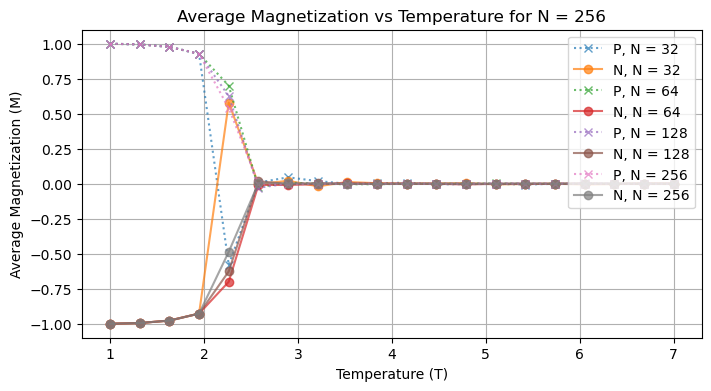

In [ ]:
alpha = 0.7

plt.figure(figsize=(8, 4))
for i, N in enumerate(Ns_opt):
    plt.plot(Ts_opt, avg_mags_p_opt[i], 'x:', label=f'P, N = {N}', alpha=alpha)
    try:
        plt.plot(Ts_opt, avg_mags_n_opt[i], 'o-', label=f'N, N = {N}', alpha=alpha)
    except:
        pass
    plt.xlabel('Temperature (T)')
    plt.ylabel('Average Magnetization (M)')
    plt.title(f'Average Magnetization vs Temperature for N = {N}')
    plt.legend(loc='upper right')
plt.grid()

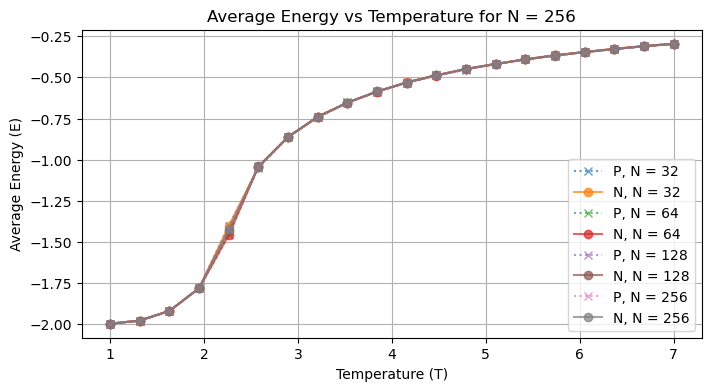

In [ ]:
plt.figure(figsize=(8, 4))
for i, N in enumerate(Ns_opt):
    plt.plot(Ts_opt, avg_energies_p_opt[i]/N**2, 'x:', label=f'P, N = {N}', alpha=alpha)
    try:
        plt.plot(Ts_opt, avg_energies_n_opt[i]/N**2, 'o-', label=f'N, N = {N}', alpha=alpha)
    except:
        pass
    plt.xlabel('Temperature (T)')
    plt.ylabel('Average Energy (E)')
    plt.title(f'Average Energy vs Temperature for N = {N}')
    plt.legend(loc='lower right')
plt.grid()

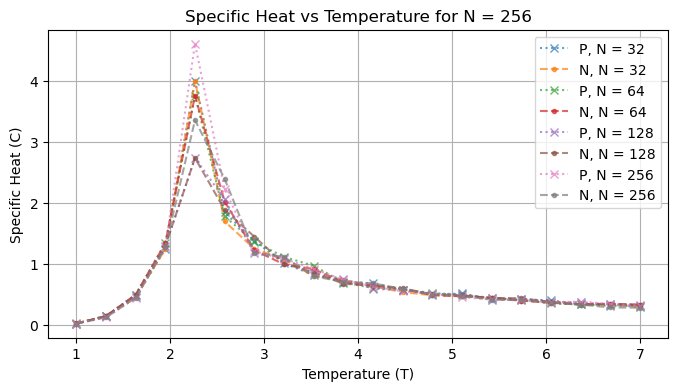

In [ ]:
plt.figure(figsize=(8, 4))
for i, N in enumerate(Ns_opt):
    plt.plot(Ts_opt, heat_capacities_p_opt[i], 'x:', label=f'P, N = {N}', alpha=alpha)
    try:
        plt.plot(Ts_opt, heat_capacities_n_opt[i], '.--', label=f'N, N = {N}', alpha=alpha)
    except:
        pass

    plt.xlabel('Temperature (T)')
    plt.ylabel('Specific Heat (C)')
    plt.title(f'Specific Heat vs Temperature for N = {N}')
    plt.legend(loc='upper right')
plt.grid()

In [ ]:
# Save the data
data_dir = Path('data')
data_dir.mkdir(exist_ok=True)  # Create directory if it doesn't exist
current_time = time.strftime("%Y-%m-%d_%H-%M-%S", time.localtime())  # Replace invalid characters
file_path = data_dir / f'Ising_model_J1_{J1}_J2_{J2}_TIME_{current_time}.npz'

np.savez(file_path, 
            Ns=Ns, 
            Ts=Ts, 
            avg_mags_p=avg_mags_p_opt, 
            avg_energies_p=avg_energies_p_opt, 
            heat_capacities_p=heat_capacities_p_opt,
            )